## Imports

In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from IPython.display import Markdown

from sklearn.model_selection import train_test_split, GridSearchCV, \
                            cross_val_score
from sklearn.dummy import DummyClassifier
# plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import confusion_matrix, \
                            recall_score, accuracy_score, \
                            roc_curve, roc_auc_score, \
                            auc, \
                            RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

# from yellowbrick.classifier import ROCAUC
# from yellowbrick.classifier.rocauc import roc_auc

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from code.model_verification import model_scoring

%matplotlib inline

In [2]:
sns.set()
sns.set(font_scale=2)

Import the `fetal_health.csv` data set, which is available
[here, via kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)  
<sup>kaggle data set was obtained via this research - 
[Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318](https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9)</sup>

In [3]:
fetal_df = pd.read_csv('./data/fetal_health.csv')

In [4]:
fetal_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [5]:
print(fetal_df.info(), \
    f"""\n\n
    Data shape: {fetal_df.shape}
    Total nulls in data set: {fetal_df.isna().sum().sum()}
    """)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

There are no nulls in this data set ... may not need to impute any data

all data is float64, may have some categories to pull out (such as
fetal health)

Let's go ahead and get the column names into formatted
titles for use later.

In [6]:
clean_titles = [column.replace('_',' ').title() for column in fetal_df.columns]

In [7]:
health_labels = ['Normal','Suspect','Pathological']

In [8]:
# display the columns that seem like they could be made
# into categorical variables, possibly at least 

print(f"""
{fetal_df.value_counts('fetal_health')}

{fetal_df.value_counts('histogram_number_of_peaks')}

{fetal_df.value_counts('histogram_number_of_zeroes')}
""")


fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64

histogram_number_of_peaks
1.0     357
2.0     331
3.0     269
4.0     258
5.0     210
6.0     158
7.0     145
0.0     107
8.0     106
9.0      67
10.0     49
11.0     28
12.0     22
13.0     10
14.0      5
16.0      2
15.0      1
18.0      1
dtype: int64

histogram_number_of_zeroes
0.0     1624
1.0      366
2.0      108
3.0       21
5.0        2
4.0        2
10.0       1
8.0        1
7.0        1
dtype: int64



The only column that seems to be able to be broken down into
a categorical value is the fetal_health column. 

### Checking the values

In [9]:
print(fetal_df.value_counts('fetal_health') , '\n\n' , fetal_df.value_counts('fetal_health', normalize=True))

fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64 

 fetal_health
1.0    0.778457
2.0    0.138758
3.0    0.082785
dtype: float64


From the [description of values in the dataset](./data/fetal_health_descriptions.md),
the values are heavily imbalanced in favor of "Normal" health.
1. Normal
2. Suspect
3. Pathological

## Determining the measure

Because the health of a child and mother are important,
the measure that this project will be employing will be
recall. It is imperative that as many suspect or
pathological cases are found as possible. An accidental
flag or false positive is more acceptable than missing
the cases where an issue is present.

This project will focus on maximizing the recall score
in an attempt to most accurately predict cases where a
pregnancy is showing potential signs of issues.

## Additional Data Preparation
### Defining X and y, creating splits

In [10]:
X = fetal_df.drop(columns=['fetal_health'])
y = fetal_df['fetal_health']

In [11]:
# we will stratify on the y values here to ensure that
# the proportion of the test and train data remains
# mostly the same, this is mostly to make sure that our
# test data actually has some of the values we are 
# targeting 
X_train, X_test, y_train, y_test = train_test_split(
                    X, y, random_state=1,
                    test_size=0.2, stratify=y
)

## Creating and Validating the Dummy Model

In [12]:
dummy_baseline = DummyClassifier(strategy='most_frequent')
dummy_baseline.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [13]:
y_train_preds = dummy_baseline.predict(X_train)
y_train_preds

array([1., 1., 1., ..., 1., 1., 1.])

In [14]:
y_train

1391    1.0
926     1.0
111     1.0
1207    1.0
897     1.0
       ... 
2027    3.0
441     1.0
1449    1.0
1512    1.0
789     1.0
Name: fetal_health, Length: 1700, dtype: float64

(array([0, 1, 2]),
 [Text(0, 0, 'Healthy'), Text(1, 0, 'Suspect'), Text(2, 0, 'Pathological')])

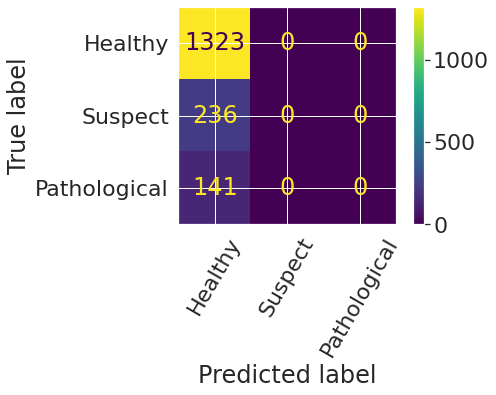

In [15]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(dummy_baseline,X_train,y_train,
    ax=ax
    #labels={1:'Healthy',2:'Suspect',3:'Pathological'}
    );

ax.set(
    yticklabels=['Healthy','Suspect','Pathological'],
    xticklabels=['Healthy','Suspect','Pathological']
);
plt.xticks(rotation=60)

Visually, we can see that the 2 labels we care about are
entirely incorrectly predicted. We'll want to over-sample
our target values to improve our predictions on them.

We'll go ahead and start creating our initial models from
here.

## Initial Models

Throughout this process, we will be using SMOTE to
perform our over-sampling. We'll perform this process
within a pipeline and will 

## Approach 1: KNN

In [16]:
initial_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])

In [17]:
initial_knn_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('knn', KNeighborsClassifier(n_jobs=-2))])

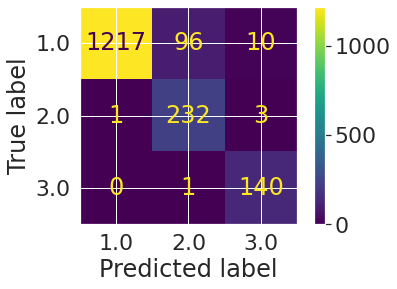

In [18]:
ConfusionMatrixDisplay.from_estimator(initial_knn_pipeline,X_train,y_train);


Model recall:         0.9652792372040908
Median ROC AUC score: 0.9980725145473125
Cross Val Score:      0.8590297653030733
    


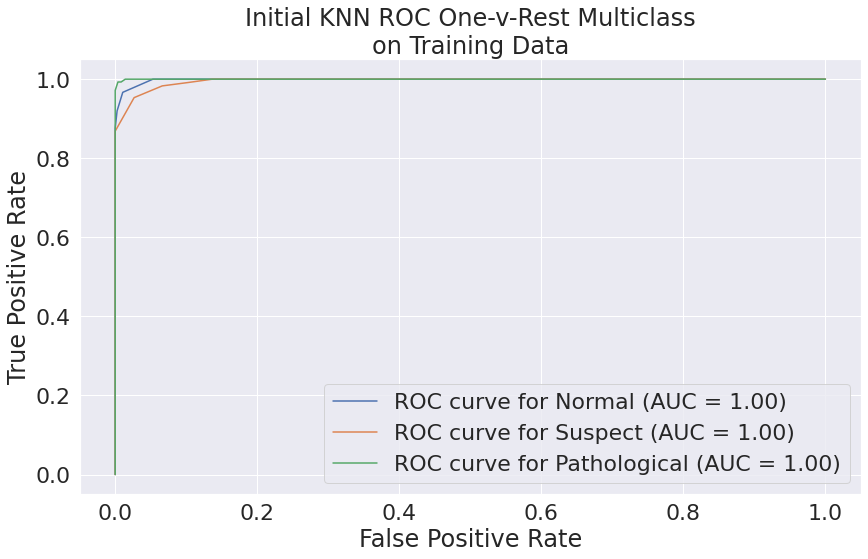

In [19]:
fig, ax = plt.subplots(figsize=(14,8))
knn_initial = model_scoring(initial_knn_pipeline,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="Initial KNN " + ax.title.get_text() + "\non Training Data"
)

'';

This model is showing 100% in all categories for its
predictions, which is... suspicious. It's very likely
that the model is extremely overfit - we'll go ahead
and run a grid search on this to see what all we can
do to tweak this model.

### Performing a grid search:

In [20]:
knn_params = {
    'o__sampling_strategy':['auto','all'],
    'knn__n_neighbors':[3,5,7],
    'knn__p':[2,3]
}

In [21]:
knn_gs = GridSearchCV(
    initial_knn_pipeline,
    param_grid=knn_params,
    n_jobs=-2,verbose=3
)

In [22]:
knn_gs.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-2))]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [3, 5, 7], 'knn__p': [2, 3],
                         'o__sampling_strategy': ['auto', 'all']},
             verbose=3)

In [23]:
knn_gs.best_params_ , knn_gs.best_estimator_ , knn_gs.best_score_

({'knn__n_neighbors': 3, 'knn__p': 2, 'o__sampling_strategy': 'auto'},
 Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                 ('knn', KNeighborsClassifier(n_jobs=-2, n_neighbors=3))]),
 0.886470588235294)


Model recall:         0.9794419644418787
Median ROC AUC score: 0.9992655715966277
Cross Val Score:      0.8577300165454071
    


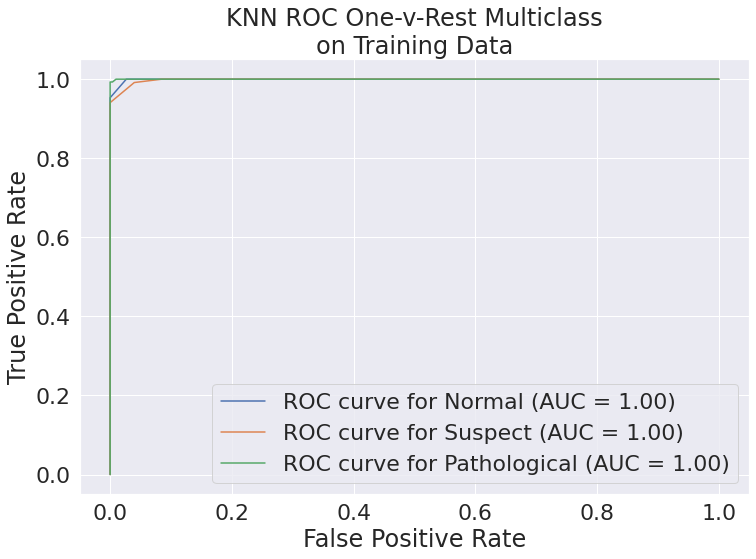

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

best_knn_initial = model_scoring(
    knn_gs.best_estimator_,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="KNN " + ax.title.get_text() + "\non Training Data"
)

'';


This model is still showing an AUC of 1 on _**ALL**_
targets. Additionally, the cross val score is much 
lower. We are still likely over-fitting pretty
heavily. We'll want to take a look at the data a
little closer and see what data is impacting this the
most and try to simplify the model to use less features
as this should improve  generalization.

### Showing that the features are not generalizing well:

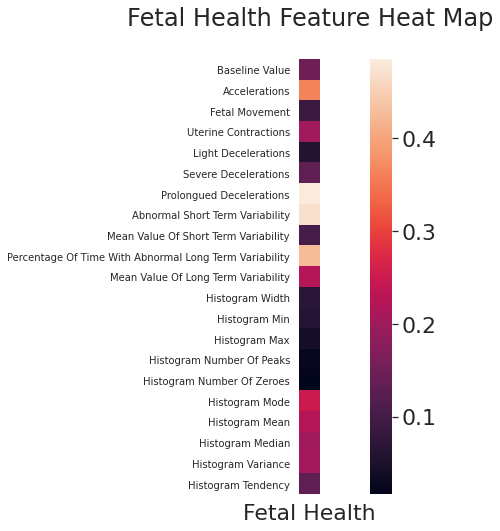

In [25]:
fig, ax = plt.subplots(figsize=(18,8))

sns.heatmap(np.abs(fetal_df.corr())[:-1][['fetal_health']],square=True,ax=ax,
yticklabels=True)

ax.yaxis.set_minor_locator(MaxNLocator(integer=True,nbins=len(clean_titles)-1))
ax.set_yticklabels(
    clean_titles[:-1],fontsize=10)
ax.set(
    title="Fetal Health Feature Heat Map\n",
    xticklabels=['Fetal Health']
)

'';

Here, we can see that there are a handful of features
that are effecting the target values

In [26]:
highest_effect = list((abs_corr_eff := np.abs(fetal_df.corr()[:-1]['fetal_health']).sort_values()).tail().index)
highest_effect, abs_corr_eff

(['histogram_mode',
  'accelerations',
  'percentage_of_time_with_abnormal_long_term_variability',
  'abnormal_short_term_variability',
  'prolongued_decelerations'],
 histogram_number_of_zeroes                                0.016682
 histogram_number_of_peaks                                 0.023666
 histogram_max                                             0.045265
 light_decelerations                                       0.058870
 histogram_min                                             0.063175
 histogram_width                                           0.068789
 fetal_movement                                            0.088010
 mean_value_of_short_term_variability                      0.103382
 severe_decelerations                                      0.131934
 histogram_tendency                                        0.131976
 baseline value                                            0.148151
 uterine_contractions                                      0.204894
 histogram_median

After extracting the 5 values with the highest 
influence on the data, we'll create a new model that
only takes these features into account when training.  
We'll create an X_test variable for use later as well.

In [27]:
X_train_top_features = X_train[highest_effect]
X_test_top_features  = X_test[highest_effect]
X_train_top_features

,histogram_mode,accelerations,percentage_of_time_with_abnormal_long_term_variability,abnormal_short_term_variability,prolongued_decelerations
1391,148.0,0.000,9.0,58.0,0.000
926,126.0,0.000,4.0,27.0,0.000
111,137.0,0.005,0.0,34.0,0.000
1207,144.0,0.006,2.0,45.0,0.000
897,150.0,0.000,0.0,32.0,0.000
...,...,...,...,...,...
2027,105.0,0.000,0.0,65.0,0.002
441,148.0,0.001,10.0,55.0,0.000
1449,157.0,0.013,0.0,36.0,0.000
1512,133.0,0.003,0.0,33.0,0.000


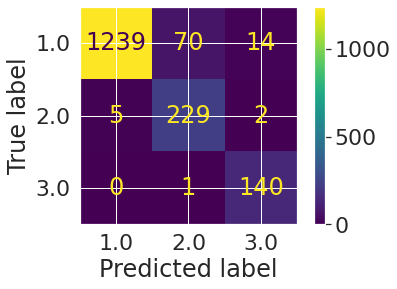

In [28]:
reduced_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])

reduced_knn_pipeline.fit(X_train_top_features,y_train)

ConfusionMatrixDisplay.from_estimator(
            reduced_knn_pipeline,X_train_top_features,y_train);


Model recall:         0.966584906992408
Median ROC AUC score: 0.9974224386560683
Cross Val Score:      0.8814828749972508
    


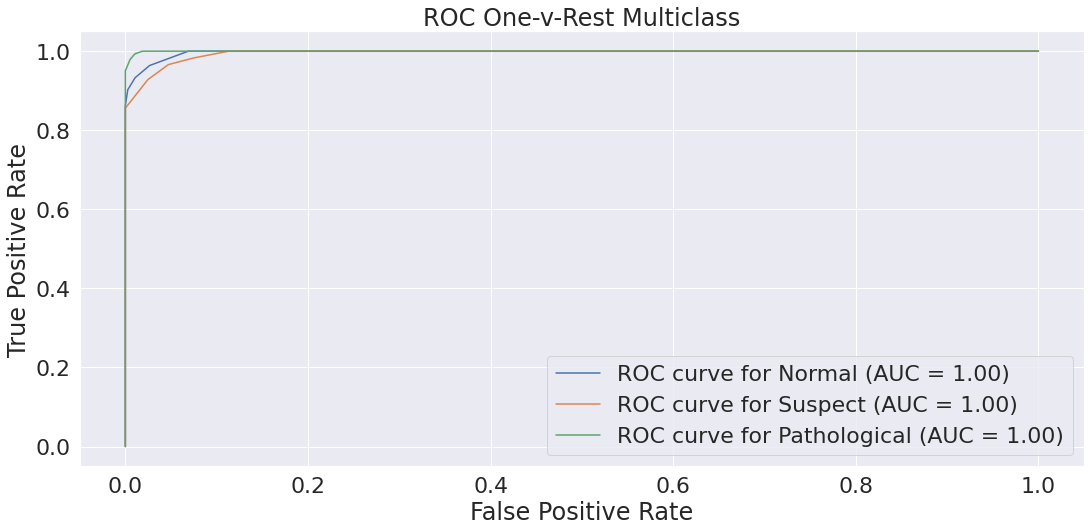

In [29]:
fig, ax = plt.subplots(figsize=(18,8))

reduced_knn_initial = model_scoring(
    reduced_knn_pipeline,X_train_top_features,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels
    
)

In [30]:
reduced_knn_initial

{'recall': 0.966584906992408,
 'rocauc': 0.9974224386560683,
 'cv_score': array([0.87668559, 0.8652186 , 0.88445164, 0.87864151, 0.90241703])}

We'll use the same options as before to generate the
grid search, so we don't have to define new params. If
we detect the model picking edges, we can investigate
those params further.

In [31]:

knn_reduced_gs = GridSearchCV(
    reduced_knn_pipeline,
    param_grid=knn_params,
    n_jobs=-2,verbose=3
)

In [32]:
knn_reduced_gs.fit(X_train_top_features,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-2))]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [3, 5, 7], 'knn__p': [2, 3],
                         'o__sampling_strategy': ['auto', 'all']},
             verbose=3)

In [33]:
knn_reduced_gs.best_params_, knn_reduced_gs.best_estimator_, knn_reduced_gs.best_score_

({'knn__n_neighbors': 3, 'knn__p': 2, 'o__sampling_strategy': 'auto'},
 Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                 ('knn', KNeighborsClassifier(n_jobs=-2, n_neighbors=3))]),
 0.9041176470588235)


Model recall:         0.9748000574593744
Median ROC AUC score: 0.998849664321822
Cross Val Score:      0.8830497561036121
    


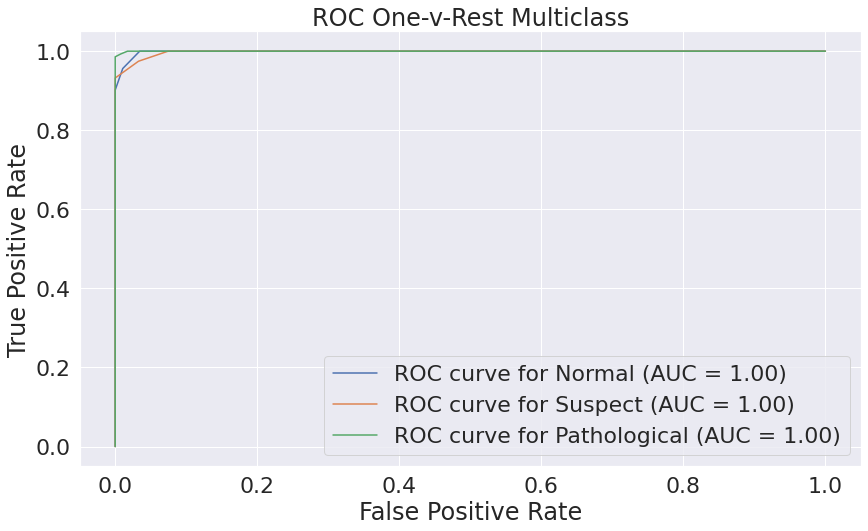

In [34]:
fig, ax = plt.subplots(figsize=(14,8))

best_knn_reduced = model_scoring(
    knn_reduced_gs.best_estimator_,
    X_train_top_features,y_train,average='macro',
    plot_curve=True,ax=ax,class_names=health_labels
)

## Investigating the Models

Now that we have a few models, we should put all of
their results into one place to really best understand
what exactly is happening with all of the scores.

In [35]:
Markdown(f"""
| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| KNN Initial |{
knn_initial['recall'] :.3f} | {
knn_initial['rocauc'] :.3f} | {
knn_initial['cv_score'].mean() :.3f} |
| Grid Searched Initial KNN | **{
best_knn_initial['recall'] :.3f}** | **{
best_knn_initial['rocauc'] :.3f}** | {
best_knn_initial['cv_score'].mean() :.3f}
| KNN Initial Reduced |{
reduced_knn_initial['recall'] :.3f} | {
reduced_knn_initial['rocauc'] :.3f} | {
reduced_knn_initial['cv_score'].mean() :.3f} | 
| Grid Searched KNN Reduced |{
best_knn_reduced['recall'] :.3f} | **{
best_knn_reduced['rocauc'] :.3f}** | **{
best_knn_reduced['cv_score'].mean() :.3f}** | """)


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| KNN Initial |0.965 | 0.998 | 0.859 |
| Grid Searched Initial KNN | **0.979** | **0.999** | 0.858
| KNN Initial Reduced |0.967 | 0.997 | 0.881 | 
| Grid Searched KNN Reduced |0.975 | **0.999** | **0.883** | 

With our highest ROC AUC and CV score, the last model
we have is our best one. It is very close to the
highest recall score we have as well, but it is very
much so our model with the best generalization 
according to our CV score. Moving forward, we'll be
comparing any new models against this one.

## Approach 2: Random Forest

### Creating the Initial Model

In [36]:
initial_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])

In [37]:
initial_tree_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('rfc',
                 RandomForestClassifier(max_depth=5, n_jobs=-2,
                                        random_state=1))])

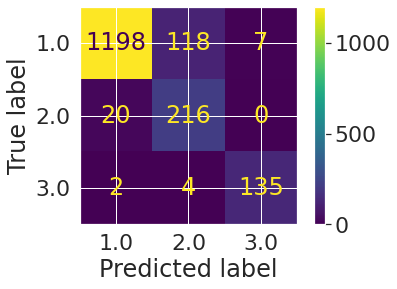

In [38]:
ConfusionMatrixDisplay.from_estimator(initial_tree_pipeline,X_train,y_train);


Model recall:         0.9260729361531314
Median ROC AUC score: 0.9849576125520768
Cross Val Score:      0.8753076894604325
    


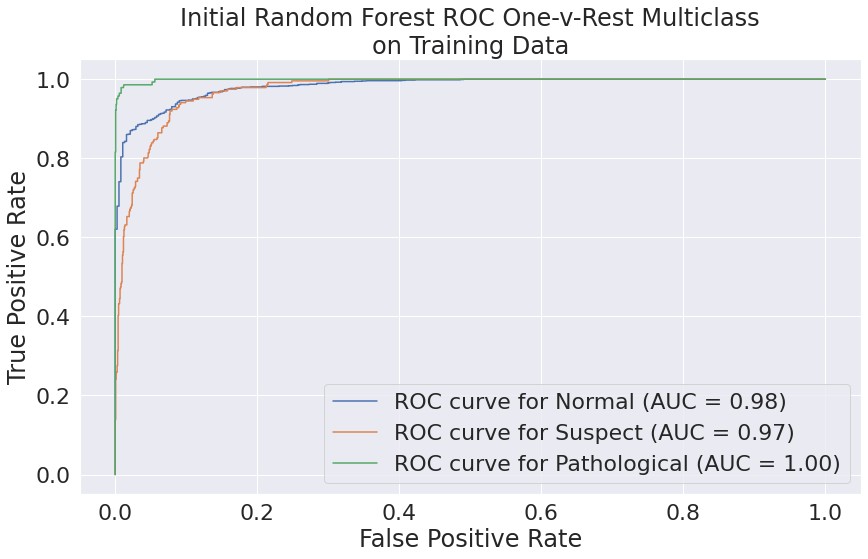

In [39]:
fig, ax = plt.subplots(figsize=(14,8))
tree_initial = model_scoring(initial_tree_pipeline,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="Initial Random Forest " + ax.title.get_text() + "\non Training Data"
)

'';

The initial model has a decent recall score at ~92.6% with
a median auc roc score of 98.5%  
As well, we already have a better CV score than our
previous models.


In [40]:
tree_params = {
    'o__sampling_strategy':['auto','all'],
    'rfc__max_depth': [3,5,7],
    'rfc__min_samples_split': [2,4,6]
}

In [41]:
tree_gs = GridSearchCV(
    initial_tree_pipeline,
    param_grid=tree_params,
    n_jobs=-2, verbose=3
)

In [42]:
tree_gs.fit(X_train,y_train)
tree_gs.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'o__sampling_strategy': 'auto',
 'rfc__max_depth': 7,
 'rfc__min_samples_split': 4}


Model recall:         0.9549041812234503
Median ROC AUC score: 0.9934588937750992
Cross Val Score:      0.9024917772848253
    


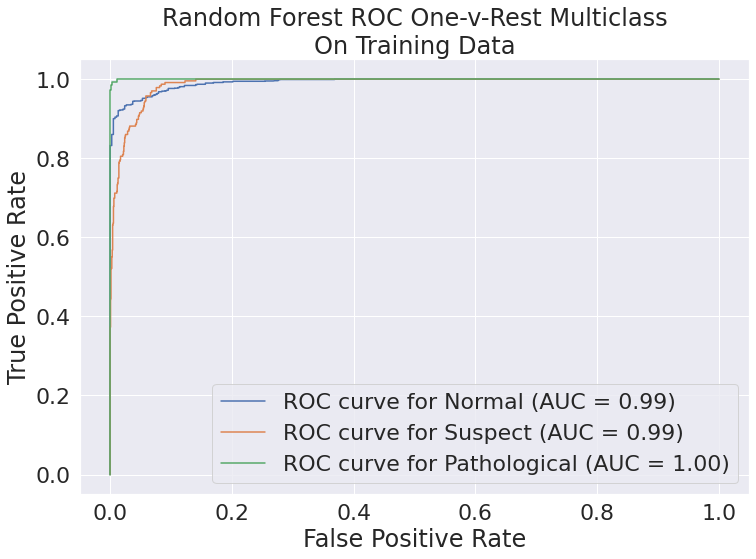

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
best_tree_initial = model_scoring(
    tree_gs.best_estimator_,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="Random Forest " + ax.title.get_text() + "\nOn Training Data"
);

Just like before, we should have the tree take a look
at a smaller set of parameters. First, we'll have the
tree look at the same subset that our KNN model did to
get a good comparison between the classifications of
both.

In [44]:
reduced_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])
reduced_tree_pipeline.fit(X_train_top_features,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('rfc',
                 RandomForestClassifier(max_depth=5, n_jobs=-2,
                                        random_state=1))])


Model recall:         0.9190744361480885
Median ROC AUC score: 0.9808657978120546
Cross Val Score:      0.8930272971851274
    


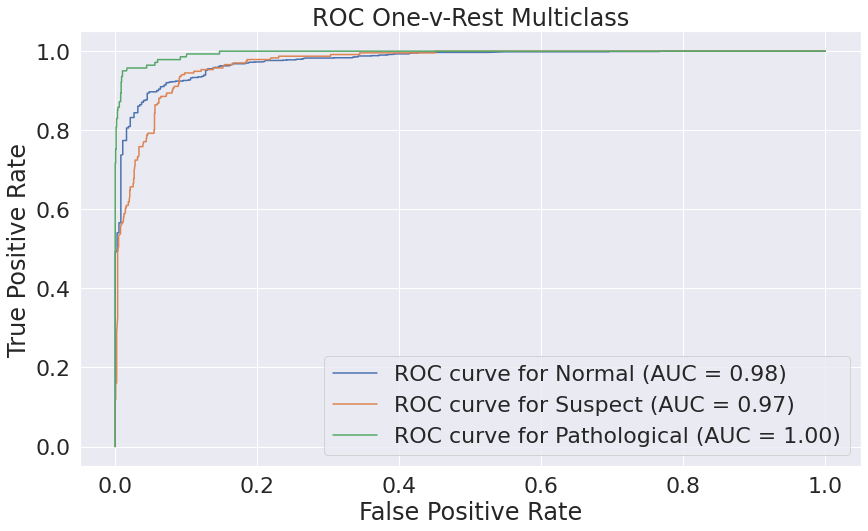

In [45]:
fig,ax = plt.subplots(figsize=(14,8))
reduced_tree_initial = model_scoring(
    reduced_tree_pipeline,
    X_train_top_features,y_train,
    average='macro',plot_curve=True,ax=ax,
    class_names=health_labels
)

It looks like the CV score actually went down when we
reduced the number of columns in the decision tree as
compared to our previous models. We'll go ahead and run
a grid search from this reduced set to see if there's a
good tweak that can be made to make the CV better.

In [46]:
reduced_tree_gs = GridSearchCV(
    reduced_tree_pipeline,
    param_grid=tree_params,
    n_jobs=-2, verbose=3)
reduced_tree_gs.fit(X_train_top_features,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('rfc',
                                        RandomForestClassifier(max_depth=5,
                                                               n_jobs=-2,
                                                               random_state=1))]),
             n_jobs=-2,
             param_grid={'o__sampling_strategy': ['auto', 'all'],
                         'rfc__max_depth': [3, 5, 7],
                         'rfc__min_samples_split': [2, 4, 6]},
             verbose=3)


Model recall:         0.9461448067092633
Median ROC AUC score: 0.9902798704926536
Cross Val Score:      0.9024995469583919
    


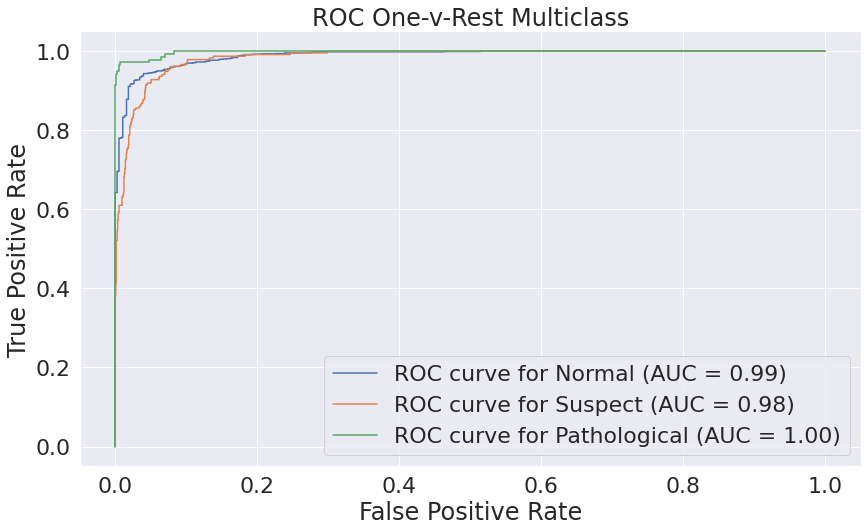

In [47]:
fig, ax = plt.subplots(figsize=(14,8))
best_tree_reduced = model_scoring(
    reduced_tree_gs.best_estimator_,
    X_train_top_features,y_train,
    average='macro',plot_curve=True,
    ax=ax, class_names=health_labels
)

And again, we'll compare the models.

In [50]:
Markdown(f"""
| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Forest Initial |{
tree_initial['recall'] :.3f} | {
tree_initial['rocauc'] :.3f} | {
tree_initial['cv_score'].mean() :.3f} |
| Grid Searched Initial Forest | **{
best_tree_initial['recall'] :.3f}** | **{
best_tree_initial['rocauc'] :.3f}** | **{
best_tree_initial['cv_score'].mean() :.3f}**
| Forest Initial Reduced |{
reduced_tree_initial['recall'] :.3f} | {
reduced_tree_initial['rocauc'] :.3f} | {
reduced_tree_initial['cv_score'].mean() :.3f} | 
| Grid Searched Forest Reduced |{
best_tree_reduced['recall'] :.3f} | {
best_tree_reduced['rocauc'] :.3f} | **{
best_tree_reduced['cv_score'].mean() :.3f}** | """)


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Forest Initial |0.926 | 0.985 | 0.875 |
| Grid Searched Initial Forest | **0.955** | **0.993** | **0.902**
| Forest Initial Reduced |0.919 | 0.981 | 0.893 | 
| Grid Searched Forest Reduced |0.946 | 0.990 | **0.902** | 

In this case, model with all of the columns actually
performs the best. It seems that there are some 
determinations in some of the smaller variables that
are fairly important when going through the decision
trees that be influencing some of the results.

Let's go ahead and put the two best models together and
see how they compare.

In [49]:
Markdown(f"""
| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Grid Searched KNN Reduced | **{
best_knn_reduced['recall'] :.3f}** | **{
best_knn_reduced['rocauc'] :.3f}** | {
best_knn_reduced['cv_score'].mean() :.3f} |
| Grid Searched Initial Forest | {
best_tree_initial['recall'] :.3f} | {
best_tree_initial['rocauc'] :.3f} | **{
best_tree_initial['cv_score'].mean() :.3f}** |""")


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Grid Searched KNN Reduced | **0.975** | **0.999** | 0.883 |
| Grid Searched Initial Forest | 0.955 | 0.993 | **0.902** |